In [97]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
import numpy as np
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg as la
import pyvista as pv
import imageio.v3 as iio
import os
import pathlib
np.set_printoptions(formatter={"float": "{:10.2f}".format})

In [99]:
exp_dir = "/home/julian/data/dmcp_experiments/middlebury/"
repr_errs = []
transforms = []
native_Ps = []
for sdir in pathlib.Path(exp_dir).glob("./*"):
    if not sdir.is_dir():
        continue
    repr_file = list(sdir.glob("reprErrs*"))[0]
    reprs = np.loadtxt(repr_file)
    repr_errs.append(reprs)

    trans_file = list(sdir.glob("transform*"))[0]
    trans = np.loadtxt(trans_file,delimiter=",")
    transforms.append(trans)

    P_file = list(sdir.glob("imP*"))[0]
    imP = np.loadtxt(P_file,delimiter=",")
    native_Ps.append(imP)

    cp_file = list(sdir.glob("cps*"))[0]


idxs = [4,5,6,7,8,16]

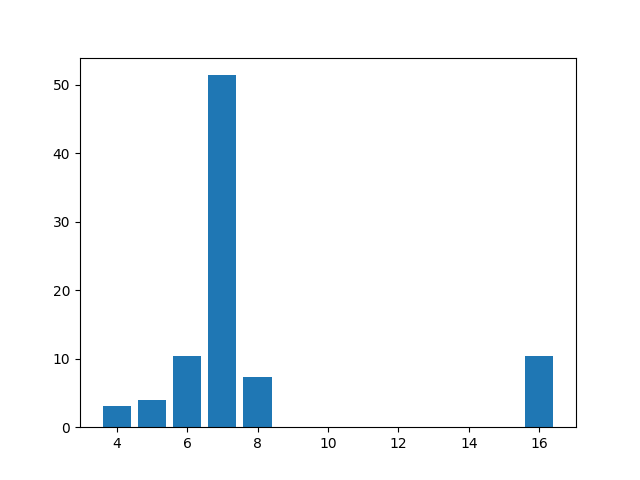

In [100]:
mean_repr_errs = [np.mean(re)  for re in repr_errs]
plt.figure()
plt.bar(idxs,mean_repr_errs)
plt.show()

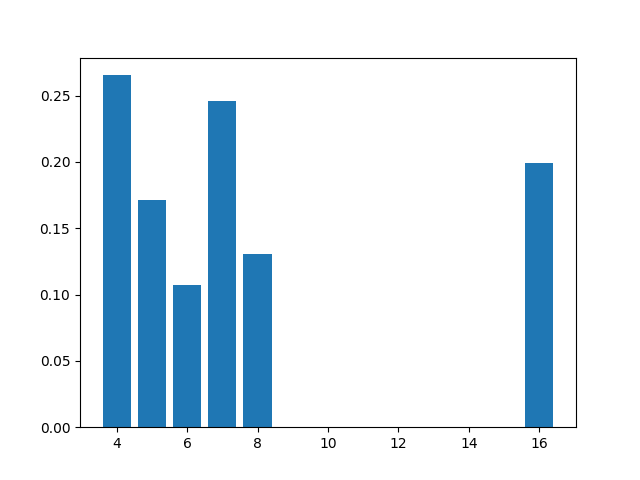

In [144]:
def pinhole_pose(P):
    pose_hat = la.null_space(P) / la.null_space(P)[-1]
    return pose_hat[:3].flatten()

world_poses = [pinhole_pose(native_Ps[i] @ la.inv(transforms[i])) for i in range(len(native_Ps))]

# error is distance to true position [0,0,0]
# pose errors are in mm(?!), we want m so divide by 10000.0
pose_errors = [la.norm(world_pose) / 1000 for world_pose in world_poses] 

plt.figure()
plt.bar(idxs, pose_errors )
plt.show()

In [145]:
mesh = pv.read("/home/julian/data/middlebury/middlebury_mesh.ply")

wpMesh = pv.PolyData(np.array(world_poses))

pl = pv.Plotter(notebook=False)
pl.add_mesh(mesh,point_size=1,scalars="RGB",rgb=True,pickable=True)
pl.add_mesh(wpMesh,color="blue",render_points_as_spheres=True,point_size=10)
pl.add_mesh(pv.Sphere(radius=100,center=[0,0,0]),color="green")
pl.show()

In [148]:
mean_pose_error = np.mean(pose_errors)
print(f"mean pose error {round(mean_pose_error,2)}m")

mean pose error 0.19m
